In [1]:
from eval_lib import Evaluator, model_loader
from importlib import reload
import os

In [2]:
import eval_lib
reload(eval_lib.evaluator)
from eval_lib.evaluator import Evaluator

In [3]:
evaluator = Evaluator()
print('lstm')
for i in (0,):
    for j in range(1):
        saves = filter(lambda file: os.path.basename(file) != "params.json", os.listdir(f'trained/lstm/{i}/{j}'))
        last_epoch = int(os.path.basename(max(saves, key = lambda file: int(os.path.basename(file).split(".")[0]))).split(".")[0])
        print(evaluator.add_model(f'trained/lstm/{i}/{j}', last_epoch, model_loader.load_lstm, f"{i}"))

print('vp_lstm')
for i in (1,):
    for j in range(1):
        saves = filter(lambda file: os.path.basename(file) != "params.json", os.listdir(f'trained/vp_lstm/{i}/{j}'))
        last_epoch = int(os.path.basename(max(saves, key = lambda file: int(os.path.basename(file).split(".")[0]))).split(".")[0])
        print(evaluator.add_model(f'trained/vp_lstm/{i}/{j}', last_epoch, model_loader.load_vp_lstm, f"{i}"))

lstm
{'in_features': 3, 'hidden_size': 64, 'num_layers': 2, 'out_features': 3, 'dropout': 0.1, 'in_noise': 0.0, 'hid_noise': 0.01, 'bidirectional': True}
vp_lstm
{'vp_bases': 8, 'vp_penalty': 0.3, 'in_features': 3, 'hidden_size': 64, 'num_layers': 2, 'out_features': 3, 'dropout': 0.1, 'in_noise': 0.0, 'hid_noise': 0.01, 'bidirectional': True}


/Users/aszfalt/Projects/wp_former/trainer_lib/utils.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_name))


{'in_features': 3, 'hidden_size': 64, 'num_layers': 2, 'out_features': 3, 'dropout': 0.1, 'in_noise': 0.0, 'hid_noise': 0.01, 'bidirectional': True}


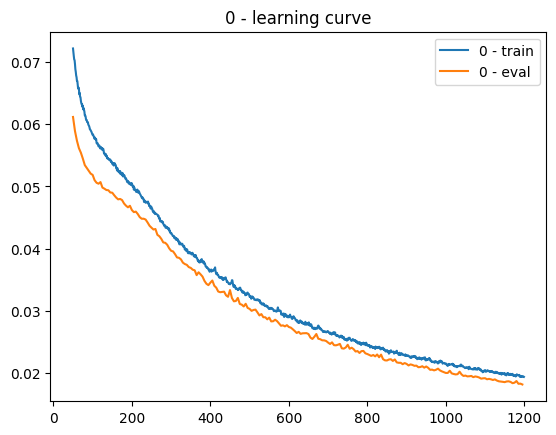

{'vp_bases': 8, 'vp_penalty': 0.3, 'in_features': 3, 'hidden_size': 64, 'num_layers': 2, 'out_features': 3, 'dropout': 0.1, 'in_noise': 0.0, 'hid_noise': 0.01, 'bidirectional': True}


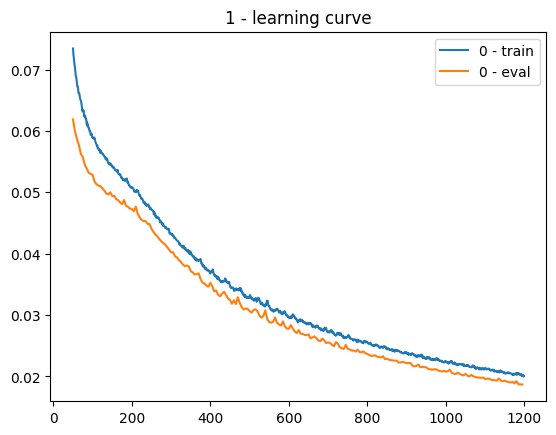

In [4]:
evaluator.plot_learning_curves(50, 1200, 5)

In [5]:
evaluator.generate_evaluation_table()

,mse,rmse,mae
0,0.0182 +- 0.0000,0.1349 +- 0.0000,0.0921 +- 0.0000
1,0.0187 +- 0.0000,0.1367 +- 0.0000,0.0942 +- 0.0000


In [6]:
from trainer_lib.datasets import TimeSeriesDatasetConfig, TimeSeriesWindowedTensorDataset
from training import load_data
import numpy as np
from matplotlib import pyplot as plt
import torch

In [7]:
sample = load_data(100000, 0)
sample = sample.interpolate(method='linear', axis=0).ffill().bfill()
sample = sample[['Wind Power [MW] (Net control)', 'Temperature [°C]', 'Wind Speed [m/s]']].to_numpy()

In [8]:
dataset_config = TimeSeriesDatasetConfig(
    src_window_size=1,
    tgt_window_size=1,
    src_sequence_length=24,
    tgt_sequence_length=6,
    step_size=1,
    add_start_token=False,
    preprocess_y=False
)
dataset = TimeSeriesWindowedTensorDataset(np.array(sample[-1000:]), dataset_config)

In [9]:
pred_len = 6
forecasts = evaluator.generate_rolling_forecasts(dataset, pred_len)

/Users/aszfalt/Projects/wp_former/eval_lib/evaluator.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt.append(dataset.get_sequence_from_y_windows(torch.tensor(tgt)).to('cpu'))


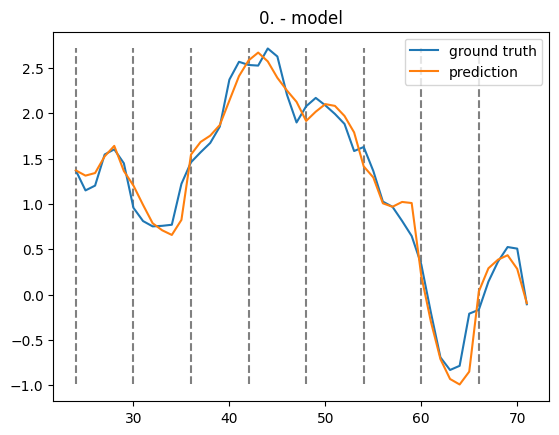

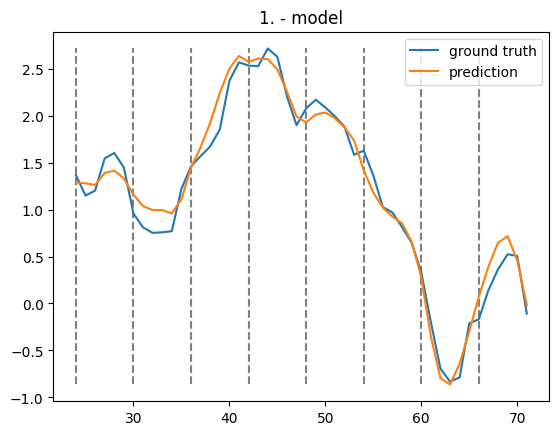

In [13]:
start = 24
end = 72
for title, (gt, p) in zip(evaluator.models.keys(), forecasts):
    gt = torch.cat([ts[:, 0] for ts in gt]).numpy()[start:end]
    p = torch.cat([ts[:, 0] for ts in p]).numpy()[start:end]
    for i in range(start, end, pred_len):
        plt.vlines(x=i, ymin=min(gt.min(), p.min()), ymax=max(gt.max(), p.max()), colors='gray', linestyles='dashed')
    plt.title(f"{title}. - model")
    plt.plot(np.arange(start, end), gt, label="ground truth")
    plt.plot(np.arange(start, end), p, label="prediction")
    plt.legend()
    plt.show()